In [34]:
import pandas as pd
import numpy as np
from typing import List

data = pd.read_csv("Real estate.csv")

data.head(5)

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [4]:
y = data.iloc[:,-1]
data.drop(['Y house price of unit area', 'No'], axis=1, inplace=True)

In [5]:
data.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
0,2012.917,32.0,84.87882,10,24.98298,121.54024
1,2012.917,19.5,306.59470,9,24.98034,121.53951
2,2013.583,13.3,561.98450,5,24.98746,121.54391
3,2013.500,13.3,561.98450,5,24.98746,121.54391
4,2012.833,5.0,390.56840,5,24.97937,121.54245


In [6]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('______')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train),columns = X_train.columns,index=X_train.index)
X_test = pd.DataFrame(data=scaler.transform(X_test),columns = X_test.columns,index=X_test.index)

In [9]:
from scipy.special import erfc

def chauvenet(array):
    mean = array.mean()
    stdv = array.std()
    criterion = 1.0/(2*(len(array)))
    d = abs(array - mean)/stdv
    prob = erfc(d)
    return prob < criterion

In [10]:
num_outliers = pd.Series(dtype='float64')
for feature in data:
    num_outliers[feature] = chauvenet(data[feature]).sum()
print(num_outliers)

X1 transaction date                        0
X2 house age                               1
X3 distance to the nearest MRT station    33
X4 number of convenience stores            0
X5 latitude                                9
X6 longitude                              15
dtype: int64


In [11]:
X_train_new = X_train.copy()
y_train_new = pd.DataFrame(y_train)



for feature in X_train_new:
    X_train_new[feature + ' outliers'] = chauvenet(X_train_new[feature])
    y_train_new[feature + ' outliers'] = chauvenet(X_train_new[feature])



features_outliers = ['X1 transaction date outliers', 'X2 house age outliers', 
            'X3 distance to the nearest MRT station outliers',
            'X4 number of convenience stores outliers',
            'X5 latitude outliers',
            'X6 longitude outliers']
for feature in features_outliers:
    X_train_new = X_train_new[X_train_new[feature] == False]
    y_train_new = y_train_new[y_train_new[feature] == False]

print(X_train_new.head(2))

X_train_new.drop(columns=features_outliers, inplace=True)
y_train_new.drop(columns=features_outliers, inplace=True)
y_train_new = pd.Series(y_train_new['Y house price of unit area'])

print("=============================")
print(X_train_new.head(2))


     X1 transaction date  X2 house age  \
234             0.636463      0.182648   
5               0.000000      0.162100   

     X3 distance to the nearest MRT station  X4 number of convenience stores  \
234                                0.349086                              0.4   
5                                  0.342468                              0.3   

     X5 latitude  X6 longitude  X1 transaction date outliers  \
234     0.339312      0.422017                         False   
5       0.375424      0.410273                         False   

     X2 house age outliers  X3 distance to the nearest MRT station outliers  \
234                  False                                            False   
5                    False                                            False   

     X4 number of convenience stores outliers  X5 latitude outliers  \
234                                     False                 False   
5                                       False              

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100, random_state=2)
rf_reg.fit(X_train_new, y_train_new)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train_new)

print('Testing set evaluation:\n______')
print_evaluate(y_test, test_pred)
print('==*******==')
print('Training set evaluation:\n_____')
print_evaluate(y_train_new, train_pred)

Testing set evaluation:
______
MAE: 4.003220281124496
MSE: 33.31160182107428
RMSE: 5.771620380887353
R2 Square 0.8014326862720433
______
==*******==
Training set evaluation:
_____
MAE: 1.9147439417989407
MSE: 10.448322646624689
RMSE: 3.2323865249417016
R2 Square 0.9372725646139208
______


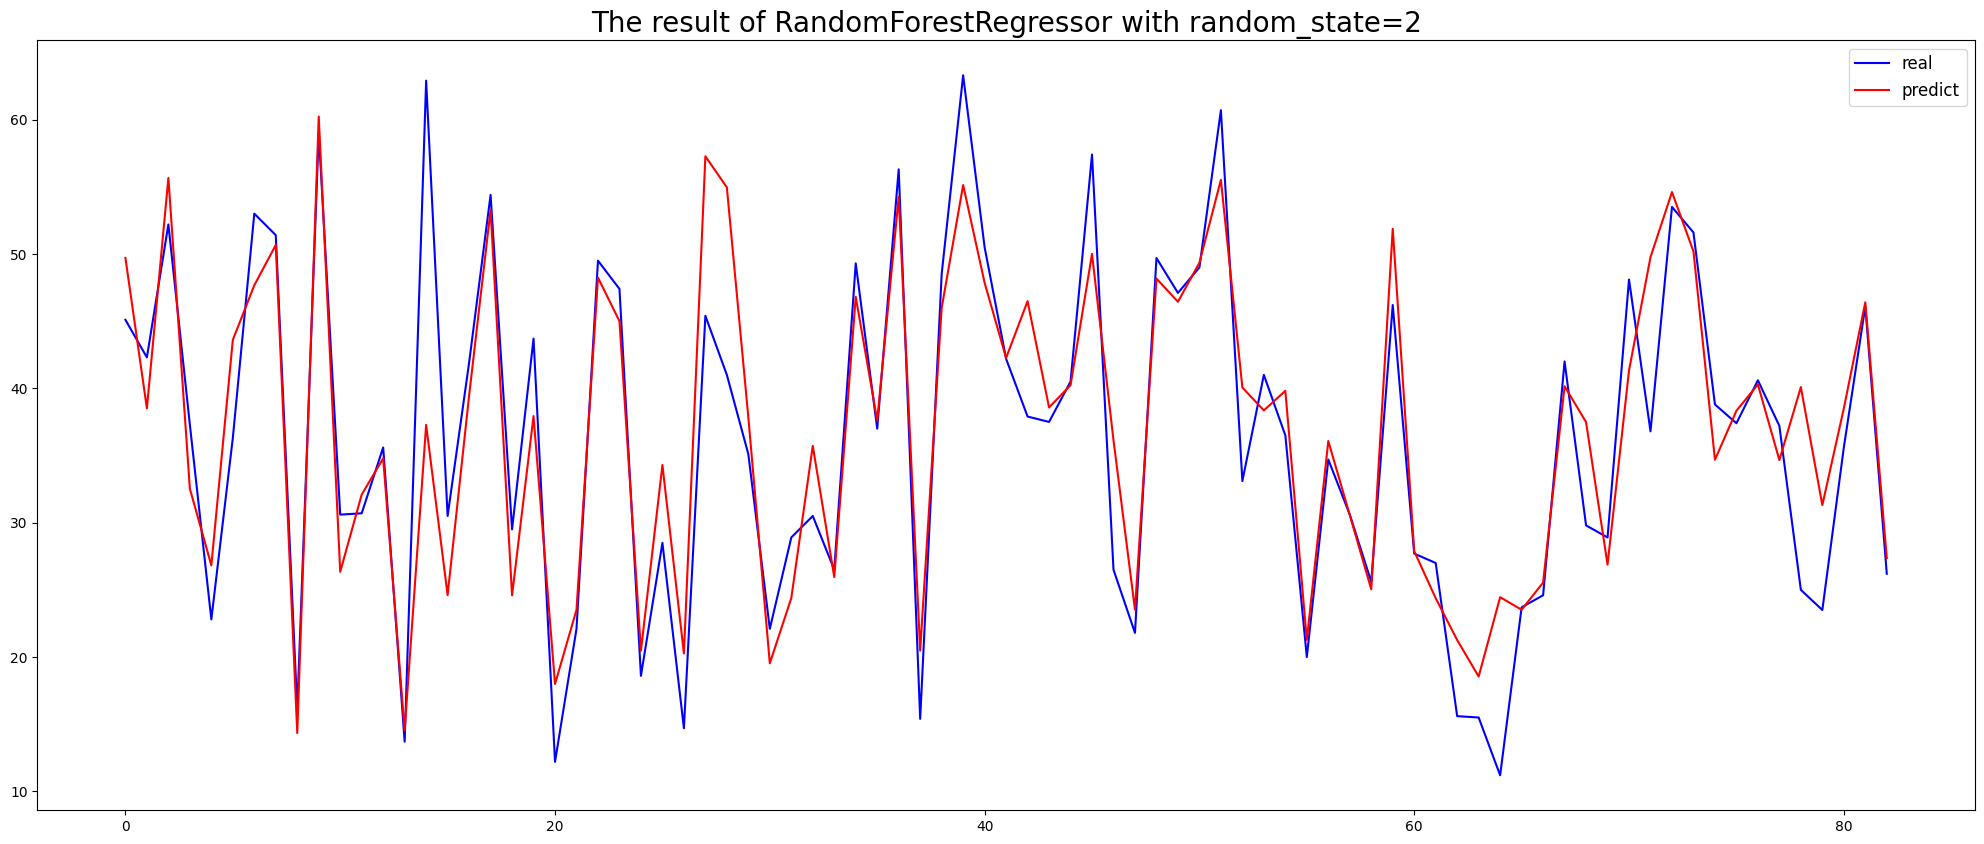

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,10))
plt.plot(y_test.to_numpy(dtype=object)[:200],c='blue')
plt.plot(test_pred[:200],c='red')
plt.annotate('outlier!', xy=(50, 115), xytext=(20, 120),arrowprops=dict(facecolor='black', shrink=0.1))
plt.legend(['real','predict'],fontsize="large")
plt.title('The result of RandomForestRegressor with random_state=2', fontsize=20)
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data,y,test_size=1, random_state=None)

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train),columns = X_train.columns,index=X_train.index)
X_test = pd.DataFrame(data=scaler.transform(X_test),columns = X_test.columns,index=X_test.index)

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100, random_state=2)
rf_reg.fit(X_train_new, y_train_new)
test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train_new)

print('Testing set evaluation:\n______')
print_evaluate(y_test, test_pred)
print('==*******==')
print('Training set evaluation:\n_____')
print_evaluate(y_train_new, train_pred)

Testing set evaluation:
______
MAE: 1.0830000000000481
MSE: 1.1728890000001042
RMSE: 1.0830000000000481
R2 Square nan
______
==*******==
Training set evaluation:
_____
MAE: 1.9147439417989407
MSE: 10.448322646624689
RMSE: 3.2323865249417016
R2 Square 0.9372725646139208
______


/home/aypa/.pyenv/versions/3.10.2/envs/venv_homeworks_sdt/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


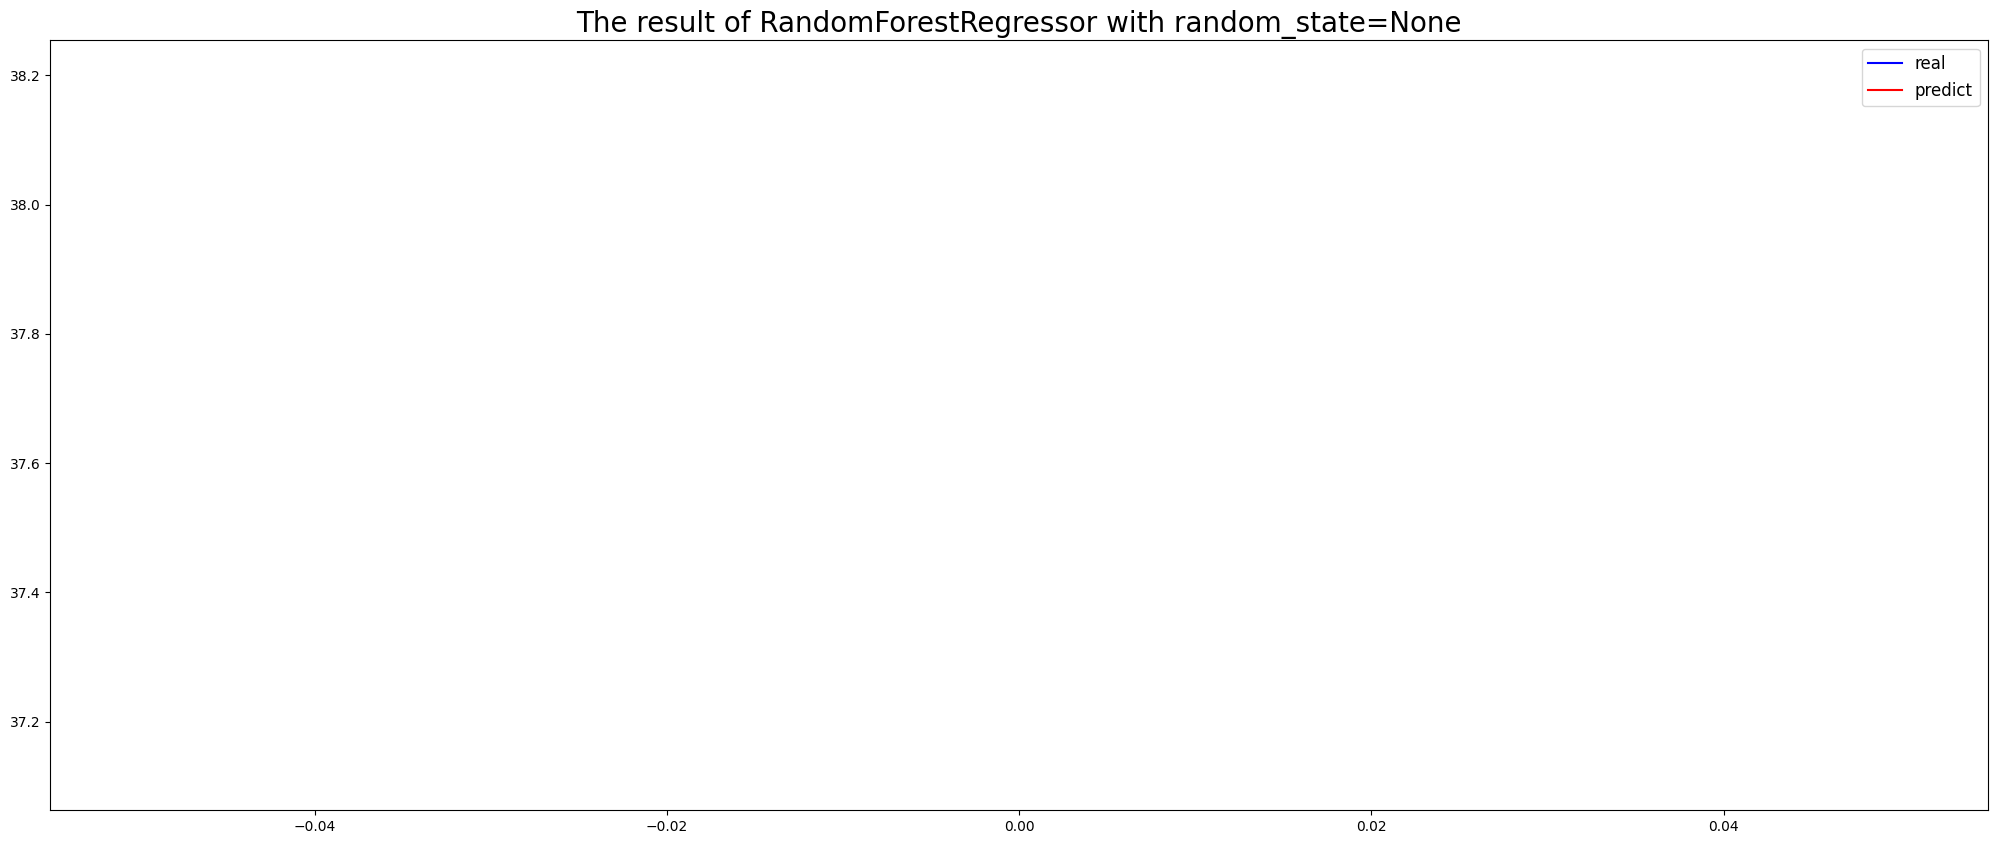

In [17]:
plt.figure(figsize=(25,10))
plt.plot(y_test.to_numpy(dtype=object)[:200],c='blue')
plt.plot(test_pred[:100],c='red')
plt.annotate('outlier!', xy=(50, 115), xytext=(20, 120),arrowprops=dict(facecolor='black', shrink=0.1))
plt.legend(['real','predict'],fontsize="large")
plt.title('The result of RandomForestRegressor with random_state=None', fontsize=20)
plt.show()

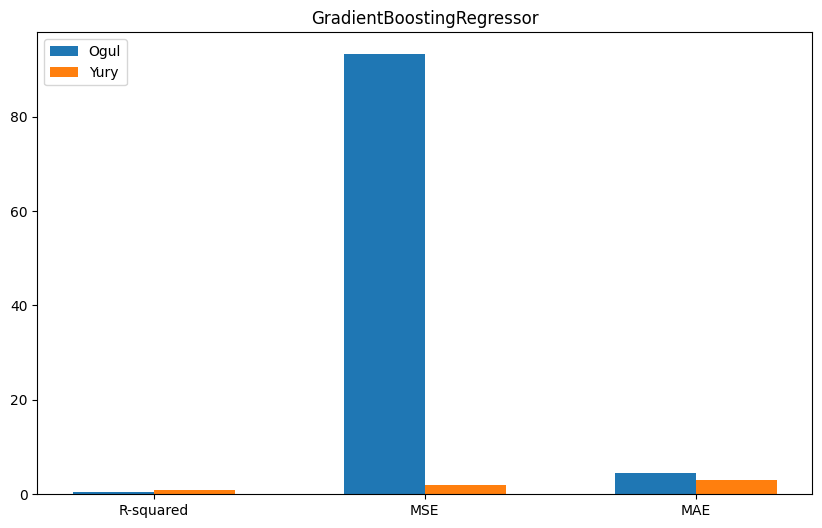

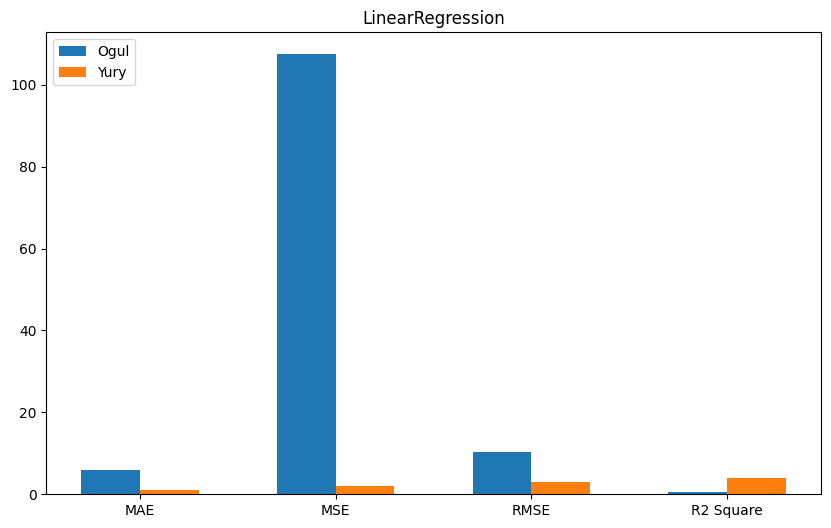

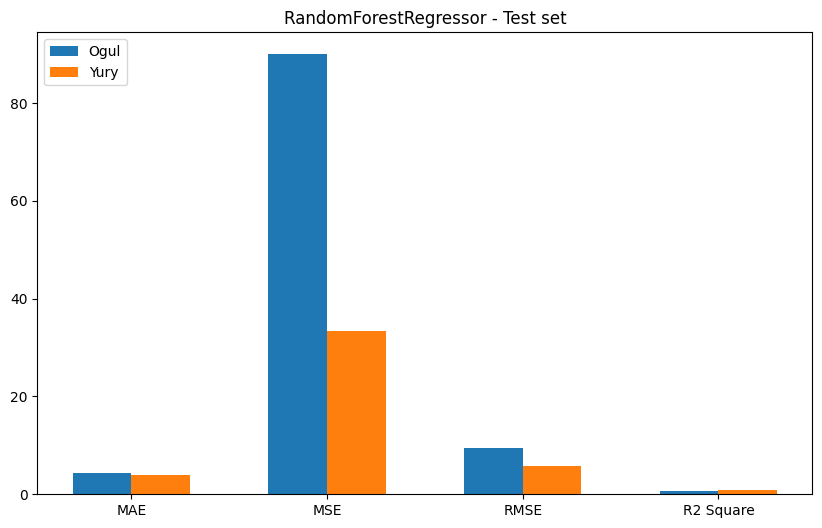

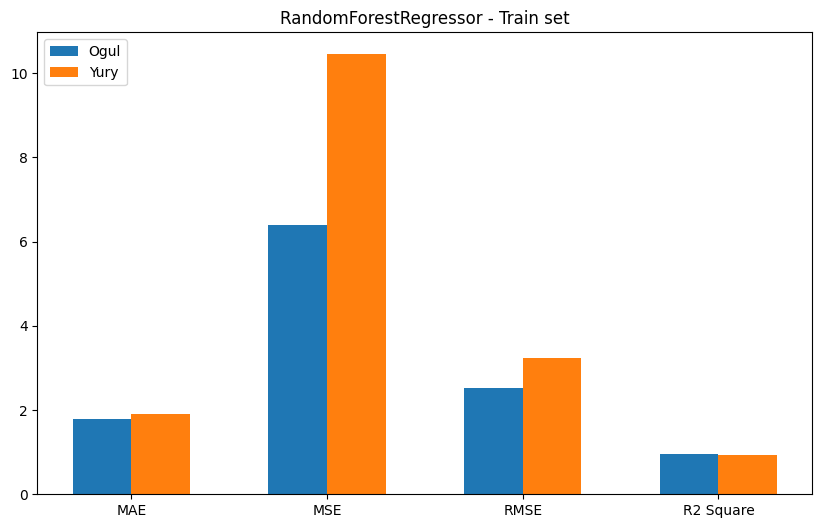

In [39]:
# best values of metrics
# MAE -> 0.0
# MSE -> 0.0
# RMSE -> should be less 180
# R2 Square -> 1.0


def show_df(
    title: str,
    columns: List[str],
    rows: List[list],
    label_x: str = "Metrics",
    label_y: str = "value",
):
    width = 0.3
    x = np.arange(len(columns))
    fig, ax = plt.subplots(figsize=(10, 6))
    labels = ["Ogul", "Yury"]
 
    rects1 = ax.bar(x - width/2, rows[0], width, label=labels[0])
    rects1 = ax.bar(x + width/2, rows[1], width, label=labels[1])
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(columns)
    ax.legend(loc='upper left')


# GradientBoostingRegressor
name_chart_GradientBoostingRegressor = "GradientBoostingRegressor"
columns_for_GradientBoostingRegressor = ["R-squared", "MSE", "MAE"]
GradientBoostingRegressor_Ogul = [0.5796002926773495, 93.19943328141828, 4.52650622749768]
GradientBoostingRegressor_Yury = [1, 2 ,3]

df_comparison_GradientBoostingRegressor = pd.DataFrame(
    np.array([
        GradientBoostingRegressor_Ogul,
        GradientBoostingRegressor_Yury
    ]),
    columns=columns_for_GradientBoostingRegressor
)
# print("=======================")
# print(name_chart_GradientBoostingRegressor)
# print("-----------------------")
# print(df_comparison_GradientBoostingRegressor)
show_df(
    name_chart_GradientBoostingRegressor,
    columns_for_GradientBoostingRegressor,
    [GradientBoostingRegressor_Ogul, GradientBoostingRegressor_Yury]
)

# LinearRegression
name_chart_LinearRegression = "LinearRegression"
columns_for_LinearRegression = ["MAE", "MSE", "RMSE", "R2 Square"]
LinearRegression_Ogul = [5.9812519106284405, 107.45657447745383, 10.36612630047762, 0.5152898373983683]
LinearRegression_Yury = [1, 2 ,3 ,4]

df_comparison_LinearRegression = pd.DataFrame(
    np.array([
        LinearRegression_Ogul,
        LinearRegression_Yury
    ]),
    columns=columns_for_LinearRegression
)
# print("=======================")
# print(name_chart_LinearRegression)
# print("-----------------------")
# print(df_comparison_LinearRegression)
show_df(
    name_chart_LinearRegression,
    columns_for_LinearRegression,
    [LinearRegression_Ogul, LinearRegression_Yury]
)

# RandomForestRegressor

#test
name_chart_RandomForestRegressor = "RandomForestRegressor - Test set"
columns_for_RandomForestRegressor = ["MAE", "MSE", "RMSE", "R2 Square"]
RandomForestRegressor_Ogul = [4.25834096385541, 89.96351775144545, 9.48491000228497, 0.5941967112801719]
RandomForestRegressor_Yury = [4.003220281124496, 33.31160182107428 ,5.771620380887353 ,0.8014326862720433]

df_comparison_RandomForestRegressor_Test_set = pd.DataFrame(
    np.array([
        RandomForestRegressor_Ogul,
        RandomForestRegressor_Yury
    ]),
    columns=columns_for_RandomForestRegressor
)
# print("=======================")
# print(name_chart_RandomForestRegressor)
# print("-----------------------")
# print(df_comparison_RandomForestRegressor_Test_set)
show_df(
    name_chart_RandomForestRegressor,
    columns_for_RandomForestRegressor,
    [RandomForestRegressor_Ogul, RandomForestRegressor_Yury]
)


#train
name_chart_RandomForestRegressor = "RandomForestRegressor - Train set"
columns_for_RandomForestRegressor = ["MAE", "MSE", "RMSE", "R2 Square"]
RandomForestRegressor_Ogul = [1.79391661631419, 6.4060702859214365, 2.5310215893827213, 0.9630478911113793]
RandomForestRegressor_Yury = [1.9147439417989407, 10.448322646624689 ,3.2323865249417016 ,0.9372725646139208]

df_comparison_RandomForestRegressor_Train_set = pd.DataFrame(
    np.array([
        RandomForestRegressor_Ogul,
        RandomForestRegressor_Yury
    ]),
    columns=columns_for_RandomForestRegressor
)

# print("=======================")
# print(name_chart_RandomForestRegressor)
# print("-----------------------")
# print(df_comparison_RandomForestRegressor_Train_set)
show_df(
    name_chart_RandomForestRegressor,
    columns_for_RandomForestRegressor,
    [RandomForestRegressor_Ogul, RandomForestRegressor_Yury]
)
